# 3. Binary Classification on real-world data

# 3.1 Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm

import gc
from tqdm import tqdm
from sklearn.datasets import load_svmlight_file

### Implementation 3.1

Select a dataset from the libsvm repository. The dataset should have at least 20 features
and 1,000 training samples.

**Downloading**

In [2]:
# from urllib.request import urlretrieve
# urlretrieve("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms", "mushrooms")
# urlretrieve("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a", "a9a")
# urlretrieve("https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a9a.t","a9a.t")

('mushrooms', <http.client.HTTPMessage at 0x16da29955b0>)

**Loading the a9a dataset**

It has :
- 32 561 samples (train) / 16 281 samples (test)
- 123 features

In [2]:
file = "mushrooms"
X, y = load_svmlight_file(file)

In [3]:
X.shape

(8124, 112)

In [4]:
X_train, y_train = X.toarray(), y

In [77]:
X_train[0]

array([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [82]:
print("The frequency of the first 10 features :", X_train.mean(axis=0)[:10])

The frequency of the first 10 features : [0.00049237 0.05563762 0.38798621 0.10192024 0.00393895 0.45002462
 0.39931068 0.31462334 0.00049237 0.28557361]


**The features seem very sparse, a lot are often empty**

Converting label 2 to -1

In [6]:
np.unique(y_train)

array([1., 2.])

In [7]:
y_train = np.where(y_train == 2, -1, y_train)

Checking if X's feature are normalized

In [8]:
X_train.mean(), X_train.std()

(0.1875, 0.3903123748998999)

X train has a constant feature

In [9]:
np.unique(X_train[:,77])

array([1.])

In [10]:
X_train = np.delete(X_train, 77, axis=1)

In [11]:
np.unique(X_train[:,77])

array([0., 1.])

**Creating a scaler class**

In [12]:
class Scaler():

    def __init__(self) -> None:
        pass

    def fit(self, X):
        # Computing the mean and std along the features
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        self.mean = mean
        self.std = std

    def transform(self, X):
        return (X-self.mean)/self.std

In [13]:
scaler = Scaler()

In [14]:
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)

In [15]:
scaled_X_train.mean(), scaled_X_train.std()

(4.727685308529284e-19, 1.000000000000008)

In [16]:
N, d = X_train.shape
print(N, d)

8124 111


### Implementation 3.2

Given your dataset, implement the associated codes for $g_S$ , $\nabla g_S$ and $\nabla^2 g_S$ , where S
is a set of random indices in {1, . . . , n}

In [17]:
class Loss():

    def __init__(
        self,
        X, 
        y, 
        lbda=None,
        regul=None,
        batch_size=None,
        grad_batch_size=None, 
        grad2_batch_size=None
    ) -> None:

        self.X = X
        self.y = y
        self.N, self.d = self.X.shape
        # we add a regularization term if needed
        self.lbda = lbda
        self.regul = regul
        # Initialize a default batch size
        self.batch_size = batch_size
        self.grad_batch_size = grad_batch_size
        self.grad2_batch_size = grad2_batch_size
        # tracking number of evaluations
        self.func_evals = 0
        self.grad_evals = 0
    
    def g_i(self, w, i):
        self.func_evals += 1
        return ( self.y[i] - (1 / (1 + np.exp(-self.X[i].dot(w)))) )**2
    
    def __call__(self, w, indexes=None):
        # Default batch size if indexes isn't given
        indexes = self.batch_size if indexes is None else indexes
        # We add the regularization term directly here and not in g_i
        # (because it would be a redundant calculation to compute the mean of a term that doesn't depend on the batch chosen)
        # This is ok bc we never actually call g_i directly outside of the class
        if self.regul == 'l1':
            regul = (self.lbda/2) * norm(w,1)
        elif self.regul == 'l2' :
            regul = (self.lbda/2) * (norm(w,2)**2)
        else :
            regul = 0
        return np.mean(self.g_i(w, indexes)) + regul
    
    def grad_i(self, w, i):
        self.grad_evals += 1
        exp_xiw = np.exp(self.X[i].dot(w))
        return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3
    
    def grad(self, w, indexes=None):
        indexes = self.grad_batch_size if indexes is None else indexes
        grad = np.zeros(self.d)
        for idx in indexes:
            grad += self.grad_i(w, idx)
        # regularization term
        if self.regul == 'l1':
            regul = (self.lbda/2) * np.sign(w)
        elif self.regul == 'l2' :
            regul = self.lbda*w
        else :
            regul = 0
        return grad/len(indexes) + regul
    
    def grad2_i(self, w, i):
        # Returns a (d,d) shape array
        self.grad_evals += self.d
        exp_xiw = np.exp(self.X[i].dot(w))
        scalar = 2 * exp_xiw * ( (exp_xiw**2 * (self.y[i]-1)) + (2 * exp_xiw - self.y[i]) ) / (1 + exp_xiw)**4
        return scalar * self.X[i].reshape(self.d, 1) @ self.X[i].reshape(1, self.d)
    
    def grad2(self, w, indexes=None):
        indexes = self.grad2_batch_size if indexes is None else indexes
        grad2 = np.zeros(shape=(self.d, self.d))
        for idx in indexes:
            grad2 += self.grad2_i(w, idx)
        # regularization term
        if self.regul == 'l1':
            regul = 0
        elif self.regul == 'l2' :
            regul = self.lbda*np.identity(self.d)
        else :
            regul = 0
        return grad2/len(indexes) + regul
    
    def get_L():
        pass

    def get_batch_L():
        pass

In [84]:
g = Loss(
    X=X_train,
    y=y_train,
    regul="l1",
    lbda=1./np.sqrt(N)
)

it makes sense to use l1 regularization here because the features are very sparse

Checking if my gradients implementation are correct :

In [85]:
# <30 seconds
from scipy.optimize import check_grad

# computing func/grad on a random point
some_w = np.random.rand(d)

print("gradient error :", check_grad(g.__call__, g.grad, some_w, np.arange(N)))

print("Hessian error :", check_grad(g.grad, g.grad2, some_w, np.arange(N)))

gradient error : 1.2588132595400352e-07
Hessian error : 1.873825697209649e-09


## 3.3 Comparison of the algorithms

### Question 10
Compare the performance of the subsampling Newton method from Section 2.1 and that of the
stochastic quasi-Newton method of Section 2.2 with a (batch) stochastic gradient approach. You may reuse
the stochastic gradient implementation from the course notebooks

In [86]:
from algorithms2 import SubNewton, BatchArmijoLineSearch, BatchBFGS, BatchLBFGS

In [87]:
np.random.seed(5)
w0 = np.random.randn(d)
print("Initial loss :",g(w0, np.arange(N)))

Initial loss : 1.8903447298689455


In [88]:
w, loss_logs, norm_logs = SubNewton(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N//10,
    grad2_batch_size=N//10,
    max_epochs=20,
    use_line_search=True,
)

 epoch   |   loss   |   norm  


       0 | 1.89e+00 | 6.16e-01:   0%|          | 0/10 [00:00<?, ?it/s]


LinAlgError: Singular matrix

The Subsampling Newton method has a singular Hessian matrix for small batch sizes

In [89]:
for batch_size in 2**np.arange(10):
    batch_idx = np.random.choice(N, size=batch_size)
    try :
        np.linalg.inv(g.grad2(w0, batch_idx))
    except:
        print("Singular matrix")

Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix
Singular matrix


However for batch_size = N (normal Newton), it is invertible

In [90]:
try :
    np.linalg.inv(g.grad2(w0, np.arange(N)))
except:
    print("Singular matrix")

Let's try with grad2_batch_size = N

In [91]:
w, loss_logs, norm_logs = SubNewton(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N,
    grad2_batch_size=N,
    max_epochs=50,
    verbose=True,
    use_line_search=True
)

 epoch   |   loss   |   norm  


       0 | 1.89e+00 | 6.16e-01:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:30: RuntimeWarning: overflow encountered in exp
  return ( self.y[i] - (1 / (1 + np.exp(-self.X[i].dot(w)))) )**2
       0 | 1.89e+00 | 6.16e-01: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

alpha too low using 1



C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:47: RuntimeWarning: overflow encountered in exp
  exp_xiw = np.exp(self.X[i].dot(w))
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: invalid value encountered in multiply
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: invalid value encountered in divide
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3


ValueError: array must not contain infs or NaNs

Even with a full Hessian, the algorithm is still very unstable (infs or NaNs), displaying the local property of this method on non-convex problems.

**Let's try again with a normalized X train :**

In [93]:
g = Loss(
    X=scaled_X_train,
    y=y_train,
    lbda=1/np.sqrt(N),
    regul="l1"
)

In [94]:
np.random.seed(5)
w0 = np.random.randn(d)
print("Initial loss :",g(w0, np.arange(N)))

Initial loss : 1.775617512538282


In [95]:
w, loss_logs, norm_logs = SubNewton(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N,
    grad2_batch_size=N,
    max_epochs=50,
    verbose=True,
    use_line_search=True,
    initial_alpha=0.01,
    theta=0.9
)

 epoch   |   loss   |   norm  


       0 | 1.78e+00 | 2.99e-01:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:30: RuntimeWarning: overflow encountered in exp
  return ( self.y[i] - (1 / (1 + np.exp(-self.X[i].dot(w)))) )**2
       0 | 1.78e+00 | 2.99e-01: 100%|██████████| 1/1 [00:03<00:00,  3.56s/it]

alpha too low using 0.01



C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:47: RuntimeWarning: overflow encountered in exp
  exp_xiw = np.exp(self.X[i].dot(w))
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: invalid value encountered in divide
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3


ValueError: array must not contain infs or NaNs

Not much better...

We could redefine the method with a safety layer when the hessian is not invertible, by replacing the hessian by the identity matrix. <br>
But that wouldn't solve the issue of having inf and NaNs, and that would be equivalent to batch stochastic gradient descent anyway. <br>
Let's try to use l2 regularization (it might help making the Hessian invertible):

In [96]:
g = Loss(
    X=scaled_X_train,
    y=y_train,
    lbda=2./np.sqrt(N),
    regul='l2'
)

In [97]:
np.random.seed(5)
w0 = np.random.randn(d)
print("Initial loss :",g(w0, np.arange(N)))

Initial loss : 2.445538117384306


Notice that the initial loss was 1.3 without the regularization, meaning with regularization half of the loss is due to the penalization

In [98]:
w, loss_logs, norm_logs = SubNewton(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N,
    grad2_batch_size=N,
    max_epochs=100,
    use_line_search=True,
    seed=1,
    theta=0.9,
    initial_alpha=0.5,
)

 epoch   |   loss   |   norm  


       0 | 2.45e+00 | 3.68e-01: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
       1 | 2.46e+00 | 3.58e-01: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


alpha too low using 0.5


       2 | 6.40e+00 | 4.64e-01:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:30: RuntimeWarning: overflow encountered in exp
  return ( self.y[i] - (1 / (1 + np.exp(-self.X[i].dot(w)))) )**2
       2 | 6.40e+00 | 4.64e-01: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]
       3 | 6.37e+00 | 4.82e-01: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]
       4 | 6.25e+00 | 4.74e-01: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
       5 | 2.91e+00 | 3.03e-01: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
       6 | 1.59e+00 | 1.83e-01: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
       7 | 1.59e+00 | 1.80e-01: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]
       8 | 1.35e+00 | 1.63e-01: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]
       9 | 1.13e+00 | 1.02e-01: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]
      10 | 1.13e+00 | 1.35e-01: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]
      11 | 1.02e+00 | 9.52e-02: 100%|██████████| 1/

alpha too low using 0.5


      12 | 4.76e+00 | 4.74e-01:   0%|          | 0/1 [00:00<?, ?it/s]C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:68: RuntimeWarning: overflow encountered in scalar power
  scalar = 2 * exp_xiw * ( (exp_xiw**2 * (self.y[i]-1)) + (2 * exp_xiw - self.y[i]) ) / (1 + exp_xiw)**4
      12 | 4.76e+00 | 4.74e-01: 100%|██████████| 1/1 [00:00<00:00,  1.49it/s]
      13 | 4.66e+00 | 5.70e-01: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
      14 | 3.86e+00 | 3.72e-01: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]
      15 | 3.76e+00 | 3.61e-01: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
      16 | 3.75e+00 | 3.67e-01: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]
      17 | 3.54e+00 | 3.86e-01: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
      18 | 2.43e+00 | 3.34e-01: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
      19 | 2.43e+00 | 3.21e-01: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]
      20 | 2.42e+00 | 3.30e-01: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]
   

alpha too low using 0.5



C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: overflow encountered in scalar multiply
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: overflow encountered in scalar power
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: invalid value encountered in divide
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X[i]) / (1 + exp_xiw)**3
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:47: RuntimeWarning: overflow encountered in exp
  exp_xiw = np.exp(self.X[i].dot(w))
C:\Users\huang\AppData\Local\Temp\ipykernel_90488\3396397676.py:48: RuntimeWarning: invalid value encountered in scalar multiply
  return (-2 * exp_xiw * (exp_xiw * (self.y[i]-1) + self.y[i]) * self.X

ValueError: array must not contain infs or NaNs

I'm giving up on the Newton method...

In [100]:
g = Loss(
    X=scaled_X_train,
    y=y_train,
    lbda=1/np.sqrt(N),
    regul="l1"
)

**Let's try Quasi-Newton BFGS**

In [101]:
#<1 min
w1, loss_logs1, norm_logs1 = BatchBFGS(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N//10,
    max_epochs=100,
    tolerance=1e-3,
    ground_truth=None,
    verbose=True,
    seed=6,
    use_line_search=True,
    theta=0.9,
    initial_alpha=0.5,
)

 epoch   |   loss   |   norm  


       0 | 1.78e+00 | 2.99e-01: 100%|██████████| 10/10 [00:00<00:00, 67.28it/s]
       1 | 9.94e-01 | 6.37e-02: 100%|██████████| 10/10 [00:00<00:00, 58.71it/s]
       2 | 8.23e-01 | 1.60e-01: 100%|██████████| 10/10 [00:00<00:00, 38.75it/s]
       3 | 6.96e-01 | 6.63e-02: 100%|██████████| 10/10 [00:00<00:00, 71.50it/s]
       4 | 6.36e-01 | 5.46e-02: 100%|██████████| 10/10 [00:00<00:00, 33.90it/s]
       5 | 6.14e-01 | 4.71e-02: 100%|██████████| 10/10 [00:00<00:00, 70.64it/s]
       6 | 6.05e-01 | 4.36e-02: 100%|██████████| 10/10 [00:00<00:00, 72.01it/s]
       7 | 6.00e-01 | 5.07e-02: 100%|██████████| 10/10 [00:00<00:00, 74.11it/s]
       8 | 5.98e-01 | 4.66e-02: 100%|██████████| 10/10 [00:00<00:00, 68.61it/s]
       9 | 5.97e-01 | 4.74e-02: 100%|██████████| 10/10 [00:00<00:00, 70.07it/s]
      10 | 5.96e-01 | 4.72e-02: 100%|██████████| 10/10 [00:00<00:00, 69.60it/s]
      11 | 5.96e-01 | 4.91e-02: 100%|██████████| 10/10 [00:00<00:00, 69.39it/s]
      12 | 5.95e-01 | 5.10e-02: 100%|███

In [119]:
#<1 min
w1_, loss_logs1_, norm_logs1_ = BatchBFGS(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N//20,
    max_epochs=100,
    tolerance=1e-3,
    ground_truth=None,
    verbose=True,
    seed=6,
    use_line_search=True,
    theta=0.9,
    initial_alpha=0.5,
)

 epoch   |   loss   |   norm  


       0 | 1.78e+00 | 2.99e-01: 100%|██████████| 20/20 [00:00<00:00, 282.34it/s]
       1 | 8.94e-01 | 9.99e-02: 100%|██████████| 20/20 [00:00<00:00, 291.35it/s]
       2 | 6.57e-01 | 5.82e-02: 100%|██████████| 20/20 [00:00<00:00, 291.92it/s]
       3 | 6.03e-01 | 5.84e-02: 100%|██████████| 20/20 [00:00<00:00, 313.44it/s]
       4 | 5.94e-01 | 5.05e-02: 100%|██████████| 20/20 [00:00<00:00, 322.34it/s]
       5 | 5.92e-01 | 4.89e-02: 100%|██████████| 20/20 [00:00<00:00, 323.30it/s]
       6 | 5.91e-01 | 4.62e-02: 100%|██████████| 20/20 [00:00<00:00, 313.17it/s]
       7 | 5.90e-01 | 5.07e-02: 100%|██████████| 20/20 [00:00<00:00, 292.98it/s]
       8 | 5.88e-01 | 4.72e-02: 100%|██████████| 20/20 [00:00<00:00, 292.28it/s]
       9 | 5.87e-01 | 4.92e-02: 100%|██████████| 20/20 [00:00<00:00, 311.43it/s]
      10 | 5.87e-01 | 4.87e-02: 100%|██████████| 20/20 [00:00<00:00, 304.68it/s]
      11 | 5.86e-01 | 5.31e-02: 100%|██████████| 20/20 [00:00<00:00, 312.37it/s]
      12 | 5.86e-01 | 5.42e-

**L-BFGS**

In [118]:
#< 1 min
w2, loss_logs2, norm_logs2 = BatchLBFGS(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N//10,
    m=2,
    max_epochs=100,
    tolerance=1e-3,
    use_line_search=True,
    theta=0.9,
    initial_alpha=0.5,
)

 epoch   |   loss   |   norm  


       0 | 1.78e+00 | 2.99e-01:   0%|          | 0/10 [00:00<?, ?it/s]

       0 | 1.78e+00 | 2.99e-01: 100%|██████████| 10/10 [00:00<00:00, 142.71it/s]
       1 | 1.05e+00 | 6.17e-02: 100%|██████████| 10/10 [00:00<00:00, 153.94it/s]
       2 | 9.92e-01 | 6.43e-02: 100%|██████████| 10/10 [00:00<00:00, 168.38it/s]
       3 | 9.49e-01 | 5.88e-02: 100%|██████████| 10/10 [00:00<00:00, 166.45it/s]
       4 | 8.58e-01 | 1.16e-01: 100%|██████████| 10/10 [00:00<00:00, 178.06it/s]
       5 | 6.81e-01 | 1.14e-01: 100%|██████████| 10/10 [00:00<00:00, 174.06it/s]
       6 | 6.24e-01 | 5.20e-02: 100%|██████████| 10/10 [00:00<00:00, 167.49it/s]
       7 | 6.03e-01 | 4.62e-02: 100%|██████████| 10/10 [00:00<00:00, 169.81it/s]
       8 | 5.99e-01 | 5.10e-02: 100%|██████████| 10/10 [00:00<00:00, 163.21it/s]
       9 | 5.97e-01 | 4.57e-02: 100%|██████████| 10/10 [00:00<00:00, 161.56it/s]
      10 | 5.96e-01 | 4.78e-02: 100%|██████████| 10/10 [00:00<00:00, 179.61it/s]
      11 | 5.95e-01 | 5.37e-02: 100%|██████████| 10/10 [00:00<00:00, 177.92it/s]
      12 | 5.94e-01 | 4.66e-

In [117]:
w2_, loss_logs2_, norm_logs2_ = BatchLBFGS(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N//20,
    m=2,
    max_epochs=100,
    tolerance=1e-3,
    use_line_search=True,
    theta=0.9,
    initial_alpha=0.5,
)

 epoch   |   loss   |   norm  


       0 | 1.78e+00 | 2.99e-01: 100%|██████████| 20/20 [00:00<00:00, 250.16it/s]
       1 | 9.51e-01 | 5.86e-02: 100%|██████████| 20/20 [00:00<00:00, 274.19it/s]
       2 | 7.94e-01 | 1.22e-01: 100%|██████████| 20/20 [00:00<00:00, 283.52it/s]
       3 | 6.63e-01 | 7.22e-02: 100%|██████████| 20/20 [00:00<00:00, 292.80it/s]
       4 | 6.22e-01 | 5.80e-02: 100%|██████████| 20/20 [00:00<00:00, 277.69it/s]
       5 | 6.09e-01 | 4.67e-02: 100%|██████████| 20/20 [00:00<00:00, 288.70it/s]
       6 | 6.06e-01 | 5.04e-02: 100%|██████████| 20/20 [00:00<00:00, 280.14it/s]
       7 | 6.04e-01 | 4.42e-02: 100%|██████████| 20/20 [00:00<00:00, 287.66it/s]
       8 | 6.03e-01 | 5.40e-02: 100%|██████████| 20/20 [00:00<00:00, 275.43it/s]
       9 | 5.99e-01 | 4.84e-02: 100%|██████████| 20/20 [00:00<00:00, 271.37it/s]
      10 | 5.97e-01 | 4.33e-02: 100%|██████████| 20/20 [00:00<00:00, 289.52it/s]
      11 | 5.97e-01 | 5.11e-02: 100%|██████████| 20/20 [00:00<00:00, 263.74it/s]
      12 | 5.97e-01 | 5.17e-

In [103]:
from algorithms2 import SGD

In [107]:
# <1 min
w3, loss_logs3, norm_logs3 = SGD(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N//10,
    max_epochs=100,
    tolerance=1e-3,
    seed=1,
    use_line_search=True,
    initial_alpha=0.5,
    theta=0.9
)

 epoch   |   loss   |   norm  


       0 | 1.78e+00 | 2.99e-01: 100%|██████████| 10/10 [00:00<00:00, 61.67it/s]
       1 | 1.40e+00 | 2.38e-01: 100%|██████████| 10/10 [00:00<00:00, 82.81it/s]
       2 | 1.18e+00 | 1.71e-01: 100%|██████████| 10/10 [00:00<00:00, 66.36it/s]
       3 | 1.09e+00 | 1.09e-01: 100%|██████████| 10/10 [00:00<00:00, 80.05it/s]
       4 | 1.05e+00 | 8.20e-02: 100%|██████████| 10/10 [00:00<00:00, 72.56it/s]
       5 | 1.02e+00 | 7.15e-02: 100%|██████████| 10/10 [00:00<00:00, 76.94it/s]
       6 | 1.00e+00 | 6.54e-02: 100%|██████████| 10/10 [00:00<00:00, 74.48it/s]
       7 | 9.84e-01 | 5.92e-02: 100%|██████████| 10/10 [00:00<00:00, 72.92it/s]
       8 | 9.70e-01 | 5.86e-02: 100%|██████████| 10/10 [00:00<00:00, 84.65it/s]
       9 | 9.57e-01 | 5.78e-02: 100%|██████████| 10/10 [00:00<00:00, 72.62it/s]
      10 | 9.44e-01 | 5.74e-02: 100%|██████████| 10/10 [00:00<00:00, 72.55it/s]
      11 | 9.33e-01 | 5.68e-02: 100%|██████████| 10/10 [00:00<00:00, 83.61it/s]
      12 | 9.22e-01 | 5.52e-02: 100%|███

In [114]:
# <1 min
w3_, loss_logs3_, norm_logs3_ = SGD(
    initial_w=w0,
    loss_class=g,
    grad_batch_size=N//20,
    max_epochs=100,
    tolerance=1e-3,
    seed=1,
    use_line_search=True,
    initial_alpha=0.5,
    theta=0.9
)

 epoch   |   loss   |   norm  


       0 | 1.78e+00 | 2.99e-01: 100%|██████████| 20/20 [00:00<00:00, 317.78it/s]
       1 | 1.18e+00 | 1.66e-01: 100%|██████████| 20/20 [00:00<00:00, 381.69it/s]
       2 | 1.05e+00 | 7.94e-02: 100%|██████████| 20/20 [00:00<00:00, 383.57it/s]
       3 | 1.00e+00 | 6.43e-02: 100%|██████████| 20/20 [00:00<00:00, 381.38it/s]
       4 | 9.71e-01 | 5.77e-02: 100%|██████████| 20/20 [00:00<00:00, 373.74it/s]
       5 | 9.45e-01 | 5.70e-02: 100%|██████████| 20/20 [00:00<00:00, 364.23it/s]
       6 | 9.22e-01 | 5.73e-02: 100%|██████████| 20/20 [00:00<00:00, 368.77it/s]
       7 | 9.01e-01 | 5.62e-02: 100%|██████████| 20/20 [00:00<00:00, 377.89it/s]
       8 | 8.81e-01 | 5.58e-02: 100%|██████████| 20/20 [00:00<00:00, 374.43it/s]
       9 | 8.62e-01 | 5.73e-02: 100%|██████████| 20/20 [00:00<00:00, 375.57it/s]
      10 | 8.41e-01 | 6.04e-02: 100%|██████████| 20/20 [00:00<00:00, 373.05it/s]
      11 | 8.20e-01 | 6.20e-02: 100%|██████████| 20/20 [00:00<00:00, 376.97it/s]
      12 | 8.01e-01 | 5.62e-

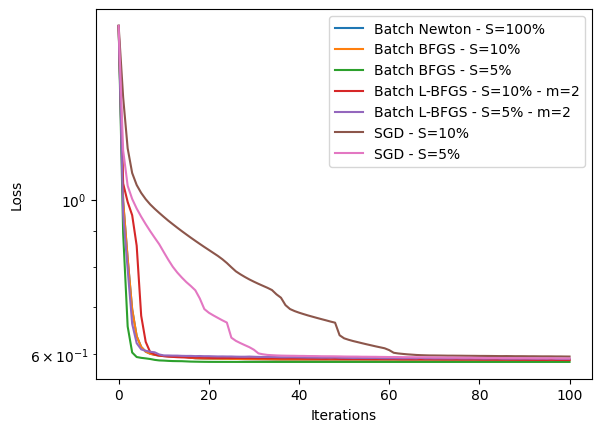

In [121]:
plt.plot(loss_logs, label="Batch Newton - S=100%")
plt.plot(loss_logs1, label="Batch BFGS - S=10%")
plt.plot(loss_logs1_, label="Batch BFGS - S=5%")
plt.plot(loss_logs2, label="Batch L-BFGS - S=10% - m=2")
plt.plot(loss_logs2_, label="Batch L-BFGS - S=5% - m=2")
plt.plot(loss_logs3, label="SGD - S=10%")
plt.plot(loss_logs3_, label="SGD - S=5%")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

**Conclusion** :
- The basic Newton method is too unstable, it is sensitive to the starting point and isn't practical due to the Hessian matrix not being invertible (not even considering the computational cost of evaluating a Hessian matrix when d is high)
- BFGS and L-BFGS are powerful variants of the basic Newton method, they're more stable.<br> L-BFGS in particular has the advantage of not having to store the approximated inverse Hessian matrix in memory which could be particularly useful if d is high, because that would be a d² square (possibly dense) matrix. For an image of 100*100 resolution, that would be a 1e8 float matrix...
- SGD is decent, but it converges slower in terms of iterations than the Quasi-Newton methods. One would argue that it doesn't approximate the Hessian matrix inverse, so the iterations are cheaper. <br>
  But in this particular case, the Quasi-Newton methods are the clear winner.
  
- For every stochastic version of the method, there is a sweet spot between selecting the batch size, too big may be too slow but more stable, too low may be faster at the beginning but too unstable. <br> 
  Our previous experiments showed that having a medium batch size (e.g. 128-512, depending on a lot of things of course) is a good compromise between stability and convergence speed

In [110]:
gc.collect()

22784

### Extra credit (optional): 
Choose a dataset with a testing set and compare the testing loss versus the training loss